# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
'''# Selecting 100k samples with 10k samples with score=1 and 10k samples with score=0
data_pos = final[final["Score"] == 1].sample(n = 50000,random_state=0)
data_neg = final[final["Score"] == 0].sample(n = 50000,random_state=0)
final = pd.concat([data_pos, data_neg])
final.shape'''

'# Selecting 100k samples with 10k samples with score=1 and 10k samples with score=0\ndata_pos = final[final["Score"] == 1].sample(n = 50000,random_state=0)\ndata_neg = final[final["Score"] == 0].sample(n = 50000,random_state=0)\nfinal = pd.concat([data_pos, data_neg])\nfinal.shape'

In [14]:
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I 

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited 

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents tp pre process the Review text. 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:25<00:00, 2501.76it/s]


In [ ]:
# Combining all the above stundents to preprocess Summary text 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

  0%|          | 213/100000 [00:00<00:46, 2123.90it/s]

In [26]:
# Preprocessed data
final["Text"]=preprocessed_reviews
final["Summary"]=preprocessed_summary
print(final.shape)
final.head()

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,every book educational,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,whole series great way spend time child,remember seeing show aired television years ag...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,entertainingl funny,beetlejuice well written movie everything exce...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,modern day fairy tale,twist rumplestiskin captured film starring mic...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,fantastic,beetlejuice excellent funny movie keaton hilar...


In [27]:
# select initial 100k data for further analysis.
final=final.iloc[:100000,:]

#Before starting featurization lets see the number of entries considered
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100000, 10)


1    87729
0    12271
Name: Score, dtype: int64

In [28]:
# splitting the review text
from sklearn.model_selection import train_test_split
preprocessed_reviews_train,preprocessed_reviews_test,y_train, y_test = train_test_split(final["Text"],final["Score"], test_size=0.20, shuffle=False)
preprocessed_reviews_train,preprocessed_reviews_cv,y_train, y_cv = train_test_split(preprocessed_reviews_train,y_train, test_size=0.25, shuffle=False)
preprocessed_reviews_train[2]

'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven not chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch'

In [29]:
# splitting the summary text
from sklearn.model_selection import train_test_split
preprocessed_summary_train,preprocessed_summary_test,y_train, y_test = train_test_split(final['Summary'],final["Score"], test_size=0.20, shuffle=False)
preprocessed_summary_train,preprocessed_summary_cv,y_train, y_cv = train_test_split(preprocessed_summary_train,y_train, test_size=0.25, shuffle=False)
preprocessed_summary_train[2]

'delight says'

In [30]:
# Function to find the length of the each review text
def length(text):
    text_length=[]
    for i in text:
        text_length.append(len(i.split()))
    return pd.DataFrame(text_length)

# [4] Featurization

## [4.1] BAG OF WORDS

In [31]:
#BoW on Review data
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

# tranforming the train, test and cv dataset into BoW features.
final_counts_train_review = count_vect.transform(preprocessed_reviews_train)
final_counts_cv_review = count_vect.transform(preprocessed_reviews_cv)
final_counts_test_review = count_vect.transform(preprocessed_reviews_test)

print("The type of count vectorizer ",type(final_counts_train_review))
print("The shape of out text BOW vectorizer ",final_counts_train_review.get_shape())
print("The number of unique words ", final_counts_train_review.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaaah', 'aaaaah']
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (60000, 45725)
The number of unique words  45725


In [32]:
#BoW on Summary data
count_vect_summary = CountVectorizer(min_df=10,max_features=500) #in scikit-learn
count_vect_summary.fit(preprocessed_summary_train)
print("some feature names ", count_vect_summary.get_feature_names()[:10])
print('='*50)

# tranforming the train, test and cv data set into BoW features.
final_counts_train_summary = count_vect_summary.transform(preprocessed_summary_train)
final_counts_cv_summary = count_vect_summary.transform(preprocessed_summary_cv)
final_counts_test_summary = count_vect_summary.transform(preprocessed_summary_test)

print("the type of count vectorizer ",type(final_counts_train_summary))
print("the shape of out text BOW vectorizer ",final_counts_train_summary.get_shape())
print("the number of unique words ", final_counts_train_summary.get_shape()[1])

some feature names  ['absolutely', 'actually', 'add', 'addicted', 'addictive', 'agave', 'almond', 'almonds', 'almost', 'alternative']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 500)
the number of unique words  500


In [33]:
# concate all the features.
from scipy.sparse import hstack
final_counts_train=hstack((final_counts_train_review, final_counts_train_summary,length(preprocessed_reviews_train)))
final_counts_cv=hstack((final_counts_cv_review, final_counts_cv_summary,length(preprocessed_reviews_cv)))
final_counts_test=hstack((final_counts_test_review, final_counts_test_summary,length(preprocessed_reviews_test)))
print("the shape of train dataset ",final_counts_train.shape)
print("the shape of cv dataset ",final_counts_cv.shape)
print("the shape of test dataset ",final_counts_test.shape)

the shape of train dataset  (60000, 46226)
the shape of cv dataset  (20000, 46226)
the shape of test dataset  (20000, 46226)


## [4.3] TF-IDF

In [34]:
# tfIDF vectorizer on review text
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews_train) # Training the tfidf model.
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# tranforming the train, test and cv data set into tfidf features.
final_tf_idf_train_review = tf_idf_vect.transform(preprocessed_reviews_train)
final_tf_idf_cv_review = tf_idf_vect.transform(preprocessed_reviews_cv)
final_tf_idf_test_review = tf_idf_vect.transform(preprocessed_reviews_test)

print("the type of count vectorizer ",type(final_tf_idf_train_review))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train_review.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train_review.get_shape()[1])

some sample features(unique words in the corpus) ['abandon', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 33420)
the number of unique words including both unigrams and bigrams  33420


In [35]:
# tfIDF on summary text
tf_idf_vect_summary = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect_summary.fit(preprocessed_summary_train) # Training the tfidf model.
print("some sample features(unique words in the corpus)",tf_idf_vect_summary.get_feature_names()[0:10])
print('='*50)

# tranforming the train, test and cv data set into tfidf features.
final_tf_idf_train_summary = tf_idf_vect_summary.transform(preprocessed_summary_train)
final_tf_idf_cv_summary = tf_idf_vect_summary.transform(preprocessed_summary_cv)
final_tf_idf_test_summary = tf_idf_vect_summary.transform(preprocessed_summary_test)

print("the type of count vectorizer ",type(final_tf_idf_train_summary))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train_summary.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train_summary.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely best', 'absolutely delicious', 'absolutely wonderful', 'acquired', 'acquired taste']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 3006)
the number of unique words including both unigrams and bigrams  3006


In [36]:
# concat all the features.
from scipy.sparse import hstack
final_tf_idf_train=hstack((final_tf_idf_train_review, final_tf_idf_train_summary,length(preprocessed_reviews_train)))
final_tf_idf_cv=hstack((final_tf_idf_cv_review, final_tf_idf_cv_summary,length(preprocessed_reviews_cv)))
final_tf_idf_test=hstack((final_tf_idf_test_review, final_tf_idf_test_summary,length(preprocessed_reviews_test)))
print("the shape of train dataset ",final_tf_idf_train.shape)
print("the shape of cv dataset ",final_tf_idf_cv.shape)
print("the shape of test dataset ",final_tf_idf_test.shape)

the shape of train dataset  (60000, 36427)
the shape of cv dataset  (20000, 36427)
the shape of test dataset  (20000, 36427)


# [5] Assignment 4: Apply Naive Bayes

## This Following Instructions was Followed While Making the Analysis:

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

# Applying Multinomial Naive Bayes

In [37]:
#============================== loading important libraries ===========================================
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

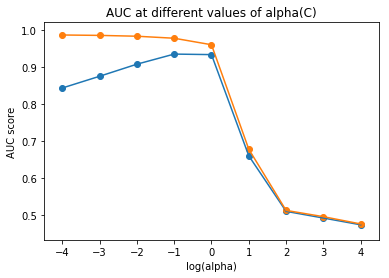

In [38]:
# Naive Bayes multinomial
from sklearn.naive_bayes import MultinomialNB
# assign the data set as train,cv and test
x_train= final_counts_train
x_cv=final_counts_cv
x_test=final_counts_test

#The hyper paramter tuning(find best Alpha)
C=[]
auc_train=[]
auc_cv=[]
for i in [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]:
    C.append(math.log10(i))
    # instantiate learning model
    clf = MultinomialNB(alpha= i, class_prior=None, fit_prior=True)

    # fitting the model on crossvalidation train
    clf.fit(x_train, y_train)

    # predict the response on the crossvalidation train
    pred_cv = clf.predict_proba(x_cv)[:,1]
    pred_train = clf.predict_proba(x_train)[:,1]

    # evaluate AUC for CV and Train 
    auc_cv.append(roc_auc_score(y_cv, pred_cv))
    auc_train.append(roc_auc_score(y_train, pred_train))

# plot the AUC of train and CV pred at different values of Alpha to find the optimal value of Alpha.
#C = map(lambda x: math.log10(x),C)
#print(C)
plt.scatter(C,auc_cv)
plt.scatter(C,auc_train)
plt.plot(C,auc_cv)
plt.plot(C,auc_train)
plt.title("AUC at different values of alpha(C)")
plt.xlabel('log(alpha)')
plt.ylabel('AUC score')
plt.show()

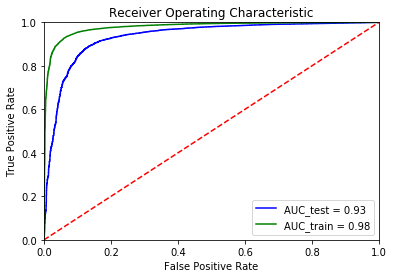

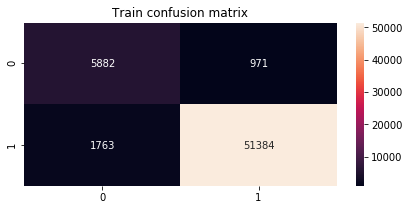

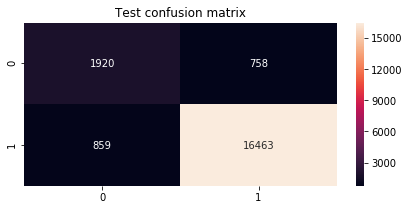

In [39]:
# Training the NB classifer with tuned hyper-parameters(alpha=.1).
clf = MultinomialNB(alpha=.1, class_prior=None, fit_prior=True)
clf.fit(x_train,y_train)
pred_test = clf.predict_proba(x_test)[:,1]
pred_train = clf.predict_proba(x_train)[:,1]

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# calculate the fpr and tpr for all thresholds of the classification
fpr_test, tpr_test, threshold = metrics.roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_test, pred_test)

fpr_train, tpr_train, threshold_tr = metrics.roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_train, pred_train)

# Representation of results
# plot ROC of train and test dataset for k=27
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC_test = %.2f' % roc_auc_test)
plt.plot(fpr_train, tpr_train, 'g', label = 'AUC_train = %.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Train confusion Matrix
df_cm = metrics.confusion_matrix(y_train, clf.predict(x_train))
plt.figure(figsize = (7,3))
plt.title("Train confusion matrix")
sns.heatmap(df_cm, annot=True,fmt="d")
plt.show()
# test confusion matrix
df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, clf.predict(x_test)))
plt.figure(figsize = (7,3))
plt.title("Test confusion matrix")
sns.heatmap(df_cm, annot=True,fmt="d")

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [40]:
# Putting extention "_summary" to the summary features.
count_vect_feature_names=list(map(lambda x:x +'_summary', count_vect_summary.get_feature_names()))

# This code is copied from here:https://stackoverflow.com/a/50530697/9607008
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()
print(np.take(count_vect.get_feature_names()+count_vect_feature_names+["Length"], pos_class_prob_sorted[-10:]))

['product' 'flavor' 'taste' 'one' 'tea' 'great' 'good' 'like' 'not'
 'Length']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [41]:
# This code is copied from here:https://stackoverflow.com/a/50530697/9607008
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
print(np.take(count_vect.get_feature_names()+count_vect_feature_names+["Length"], neg_class_prob_sorted[-10:]))

['no' 'not_summary' 'good' 'one' 'taste' 'product' 'would' 'like' 'not'
 'Length']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

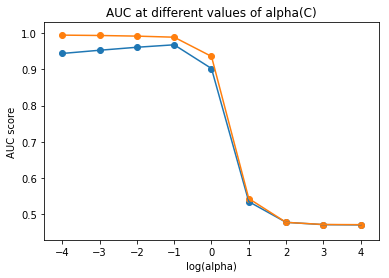

In [42]:
# assign the data set as train,cv and test
x_train= final_tf_idf_train
x_cv=final_tf_idf_cv
x_test=final_tf_idf_test

#The hyper paramter tuning(find best Alpha)
C=[]
auc_train=[]
auc_cv=[]
for i in [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]:
    C.append(math.log10(i))
    # instantiate learning model
    clf = MultinomialNB(alpha= i, class_prior=None, fit_prior=True)

    # fitting the model on crossvalidation train
    clf.fit(x_train, y_train)

    # predict the response on the crossvalidation train
    pred_cv = clf.predict_proba(x_cv)[:,1]
    pred_train = clf.predict_proba(x_train)[:,1]

    # evaluate AUC for CV and Train 
    auc_cv.append(roc_auc_score(y_cv, pred_cv))
    auc_train.append(roc_auc_score(y_train, pred_train))

# plot the AUC of train and CV pred at different values of Alpha to find the optimal value of Alpha.
#C = map(lambda x: math.log10(x),C)
#print(C)
plt.scatter(C,auc_cv)
plt.scatter(C,auc_train)
plt.plot(C,auc_cv)
plt.plot(C,auc_train)
plt.title("AUC at different values of alpha(C)")
plt.xlabel('log(alpha)')
plt.ylabel('AUC score')
plt.show()

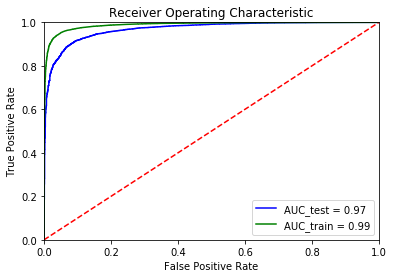

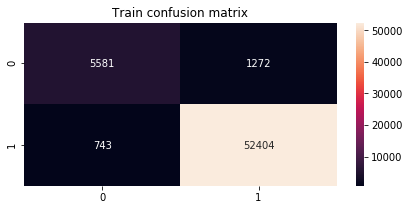

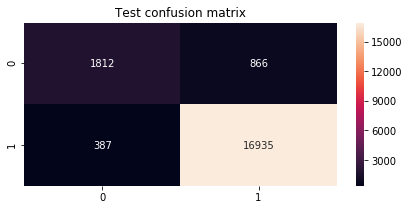

In [43]:
# Training the NB classifer with tuned hyper-parameters.
clf = MultinomialNB(alpha= .1, class_prior=None, fit_prior=True)
clf.fit(x_train,y_train)
pred_test = clf.predict_proba(x_test)[:,1]
pred_train = clf.predict_proba(x_train)[:,1]

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# calculate the fpr and tpr for all thresholds of the classification
fpr_test, tpr_test, threshold = metrics.roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_test, pred_test)

fpr_train, tpr_train, threshold_tr = metrics.roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_train, pred_train)

# Representation of results
# plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC_test = %.2f' % roc_auc_test)
plt.plot(fpr_train, tpr_train, 'g', label = 'AUC_train = %.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Representation of results
# Train confusion Matrix
df_cm = metrics.confusion_matrix(y_train, clf.predict(x_train))
plt.figure(figsize = (7,3))
plt.title("Train confusion matrix")
sns.heatmap(df_cm, annot=True,fmt="d")
plt.show()
# test confusion matrix
df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, clf.predict(x_test)))
plt.figure(figsize = (7,3))
plt.title("Test confusion matrix")
sns.heatmap(df_cm, annot=True,fmt="d")

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [44]:
# Putting extention "_summary" to the summary features.
tf_idf_vect_feature_names=list(map(lambda x:x +'_summary', tf_idf_vect_summary.get_feature_names()))

# This code is copied from here:https://stackoverflow.com/a/50530697/9607008
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()
print(np.take(tf_idf_vect.get_feature_names()+ tf_idf_vect_feature_names+["Length"], pos_class_prob_sorted[-10:]))

['tea' 'tea_summary' 'great' 'love_summary' 'delicious_summary' 'not'
 'best_summary' 'good_summary' 'great_summary' 'Length']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [45]:
# This code is copied from here:https://stackoverflow.com/a/50530697/9607008
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
print(np.take(tf_idf_vect.get_feature_names()+ tf_idf_vect_feature_names+["Length"], neg_class_prob_sorted[-10:]))

['one' 'disappointed_summary' 'taste_summary' 'taste' 'would' 'product'
 'like' 'not' 'not_summary' 'Length']


# [6] Conclusions

In [46]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Algorithem", "vectorization", "Hyper parameter","AUC Score"]

x.add_row(["NB","MultinomialNB","BOW",       .1,0.93])
x.add_row(["NB","MultinomialNB","tf-IDF",    .1,0.97])

print(x)

ModuleNotFoundError: No module named 'prettytable'